Fetching data...


/var/folders/0x/cpw5m7p54c7bkvtwg77cln500000gn/T/ipykernel_29138/3690998013.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  5 of 5 completed



Assets: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
Annualized Returns:
Ticker
AAPL     0.2990
AMZN     0.1890
GOOGL    0.2352
MSFT     0.2758
TSLA     0.7736
dtype: float64

Correlation Matrix:
Ticker   AAPL   AMZN  GOOGL   MSFT   TSLA
Ticker                                   
AAPL    1.000  0.624  0.691  0.777  0.511
AMZN    0.624  1.000  0.664  0.679  0.454
GOOGL   0.691  0.664  1.000  0.773  0.428
MSFT    0.777  0.679  0.773  1.000  0.472
TSLA    0.511  0.454  0.428  0.472  1.000

Generating random portfolios...
Optimizing efficient frontier...

MAXIMUM SHARPE RATIO PORTFOLIO:
Expected Return: 0.5403 (54.03%)
Volatility: 0.4508 (45.08%)
Sharpe Ratio: 1.1543

Optimal Weights:
  AAPL: 26.96%
  MSFT: 0.00%
  GOOGL: 0.00%
  AMZN: 21.17%
  TSLA: 51.88%


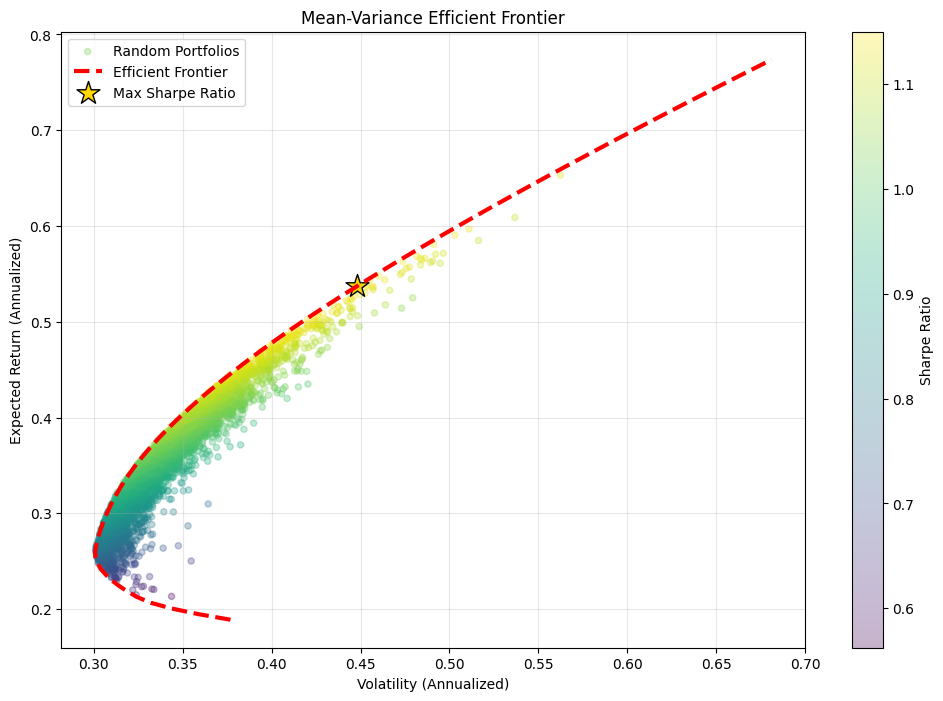

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import Tuple, Dict, List

def fetch_returns(tickers: List[str], start: str, end: str) -> pd.DataFrame:
    """Download adjusted close prices and calculate daily returns."""
    prices = yf.download(tickers, start=start, end=end)['Close']
    returns = prices.pct_change().dropna()
    return returns

def portfolio_performance(weights: np.ndarray, mean_returns: pd.Series, cov_matrix: pd.DataFrame) -> Tuple[float, float]:
    """Calculate portfolio expected return and volatility."""
    portfolio_return = np.sum(mean_returns * weights) * 252  # Annualized
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return portfolio_return, portfolio_vol

def negative_sharpe_ratio(weights: np.ndarray, mean_returns: pd.Series, cov_matrix: pd.DataFrame, risk_free_rate: float = 0.02) -> float:
    """Negative Sharpe ratio for maximization (minimization of negative value)."""
    p_return, p_vol = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe = (p_return - risk_free_rate) / p_vol
    return -sharpe

def portfolio_volatility(weights: np.ndarray, mean_returns: pd.Series, cov_matrix: pd.DataFrame) -> float:
    """Portfolio volatility for minimization."""
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

def optimize_portfolio(mean_returns: pd.Series, cov_matrix: pd.DataFrame, target_return: float = None) -> Dict:
    """
    Optimize portfolio weights.
    If target_return is None, finds maximum Sharpe ratio portfolio.
    Otherwise, finds minimum volatility for target return.
    """
    n_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # weights sum to 1
    
    bounds = tuple((0, 1) for _ in range(n_assets))  # no short selling
    
    if target_return is None:
        # Max Sharpe ratio portfolio
        result = minimize(negative_sharpe_ratio, n_assets * [1./n_assets], args=args,
                         method='SLSQP', bounds=bounds, constraints=constraints)
    else:
        # Min volatility for target return
        constraints.append({'type': 'eq', 'fun': lambda x: np.sum(mean_returns * x) * 252 - target_return})
        result = minimize(portfolio_volatility, n_assets * [1./n_assets], args=args,
                         method='SLSQP', bounds=bounds, constraints=constraints)
    
    return {
        'weights': result.x,
        'return': portfolio_performance(result.x, mean_returns, cov_matrix)[0],
        'volatility': portfolio_performance(result.x, mean_returns, cov_matrix)[1],
        'success': result.success
    }

def generate_efficient_frontier(mean_returns: pd.Series, cov_matrix: pd.DataFrame, n_portfolios: int = 100) -> pd.DataFrame:
    """Generate efficient frontier by optimizing for range of target returns."""
    min_return = mean_returns.min() * 252
    max_return = mean_returns.max() * 252
    target_returns = np.linspace(min_return, max_return, n_portfolios)
    
    efficient_portfolios = []
    for target in target_returns:
        try:
            opt = optimize_portfolio(mean_returns, cov_matrix, target_return=target)
            if opt['success']:
                efficient_portfolios.append({
                    'Return': opt['return'],
                    'Volatility': opt['volatility'],
                    'Sharpe': (opt['return'] - 0.02) / opt['volatility'],
                    **{f'Weight_{i}': w for i, w in enumerate(opt['weights'])}
                })
        except:
            continue
    
    return pd.DataFrame(efficient_portfolios)

def plot_efficient_frontier(efficient_frontier: pd.DataFrame, random_portfolios: pd.DataFrame = None):
    """Plot the efficient frontier with optional random portfolios scatter."""
    plt.figure(figsize=(12, 8))
    
    # Plot random portfolios if provided
    if random_portfolios is not None:
        plt.scatter(random_portfolios['Volatility'], random_portfolios['Return'], 
                   c=random_portfolios['Sharpe'], cmap='viridis', 
                   s=20, alpha=0.3, label='Random Portfolios')
        plt.colorbar(label='Sharpe Ratio')
    
    # Plot efficient frontier
    plt.plot(efficient_frontier['Volatility'], efficient_frontier['Return'], 
            'r--', linewidth=3, label='Efficient Frontier')
    
    # Highlight max Sharpe ratio portfolio
    max_sharpe_idx = efficient_frontier['Sharpe'].idxmax()
    plt.scatter(efficient_frontier.loc[max_sharpe_idx, 'Volatility'], 
               efficient_frontier.loc[max_sharpe_idx, 'Return'], 
               marker='*', s=300, c='gold', edgecolors='black', 
               label='Max Sharpe Ratio')
    
    plt.xlabel('Volatility (Annualized)')
    plt.ylabel('Expected Return (Annualized)')
    plt.title('Mean-Variance Efficient Frontier')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def generate_random_portfolios(mean_returns: pd.Series, cov_matrix: pd.DataFrame, n_portfolios: int = 5000) -> pd.DataFrame:
    """Generate random portfolios for visualization."""
    n_assets = len(mean_returns)
    returns, volatilities, sharpe_ratios = [], [], []
    all_weights = []
    
    for _ in range(n_portfolios):
        weights = np.random.random(n_assets)
        weights /= np.sum(weights)
        
        p_return, p_vol = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe = (p_return - 0.02) / p_vol
        
        returns.append(p_return)
        volatilities.append(p_vol)
        sharpe_ratios.append(sharpe)
        all_weights.append(weights)
    
    return pd.DataFrame({
        'Return': returns,
        'Volatility': volatilities,
        'Sharpe': sharpe_ratios,
        'Weights': all_weights
    })

def main():
    """Example usage with 5 tech stocks."""
    # Configuration
    TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
    START_DATE = '2020-01-01'
    END_DATE = '2024-01-01'
    RISK_FREE_RATE = 0.02  # 2% annual
    
    # 1. Load data
    print("Fetching data...")
    returns = fetch_returns(TICKERS, START_DATE, END_DATE)
    
    # 2. Calculate statistics
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    print(f"\nAssets: {TICKERS}")
    print(f"Annualized Returns:\n{(mean_returns * 252).round(4)}")
    print(f"\nCorrelation Matrix:\n{returns.corr().round(3)}")
    
    # 3. Generate random portfolios for visualization
    print("\nGenerating random portfolios...")
    random_portfolios = generate_random_portfolios(mean_returns, cov_matrix, n_portfolios=5000)
    
    # 4. Calculate efficient frontier
    print("Optimizing efficient frontier...")
    efficient_frontier = generate_efficient_frontier(mean_returns, cov_matrix, n_portfolios=100)
    
    # 5. Get maximum Sharpe ratio portfolio
    max_sharpe_port = optimize_portfolio(mean_returns, cov_matrix, target_return=None)
    print(f"\n{'='*50}")
    print("MAXIMUM SHARPE RATIO PORTFOLIO:")
    print(f"{'='*50}")
    print(f"Expected Return: {max_sharpe_port['return']:.4f} ({max_sharpe_port['return']*100:.2f}%)")
    print(f"Volatility: {max_sharpe_port['volatility']:.4f} ({max_sharpe_port['volatility']*100:.2f}%)")
    print(f"Sharpe Ratio: {(max_sharpe_port['return'] - RISK_FREE_RATE) / max_sharpe_port['volatility']:.4f}")
    print("\nOptimal Weights:")
    for i, (ticker, weight) in enumerate(zip(TICKERS, max_sharpe_port['weights'])):
        print(f"  {ticker}: {weight:.2%}")
    
    # 6. Plot
    plot_efficient_frontier(efficient_frontier, random_portfolios)

if __name__ == "__main__":
    main()